#### Load the input pdf files and merge them as one large docuemnt 

In [1]:
from PyPDF2 import PdfMerger
import os

pdf_folder = "/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Input_Data/health-plan"
output_pdf_path = "/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf"

# Collect all PDF files
pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]

# Merge them
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)

# Save the result
merger.write(output_pdf_path)
merger.close()

In [2]:
from langchain_community.document_loaders import PyPDFLoader

# Load the single combined PDF
loader = PyPDFLoader(output_pdf_path)
documents = loader.load()

print(f"Loaded {len(documents)} pages from merged file.")

Loaded 263 pages from merged file.


### Total Characters count for the merged file 

In [3]:
# Extract and join text from all pages
full_text = ""
for page in documents:
    full_text += page.page_content or ""

# Count characters
character_count = len(full_text)

print(f"Total characters in '{output_pdf_path}': {character_count}")


Total characters in '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf': 589147


In [4]:
##assert len(documents) == 1
print(f"Total characters: {len(documents[0].page_content)}")

Total characters: 42


### Splitting the document into sub documents

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 850, # chunk size (characters)
    chunk_overlap=100,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(documents)

print(f"Splitted the merged document into {len(all_splits)} sub-documents.")

Splitted the merged document into 890 sub-documents.


### Checked with open Source embeddings from huggingface to vectorize and store it locally

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

if all_splits:
	embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
	vectorstore = FAISS.from_documents(all_splits, embedding_model)
	vectorstore.save_local("vector_index")
else:
	print("No chunks found. Please check your document loading and splitting steps.")


/tmp/ipykernel_44580/468630919.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
document_ids = vectorstore.add_documents(documents=all_splits)

print(document_ids[:3])

['59e15e0b-5b87-41a9-bb18-afee49033835', '8c2478a5-fce7-4837-9fa7-44c38c0cfce4', '7b32eca9-4538-41a4-a241-f6a8abf5f0fb']


In [8]:
query = "What are covered services in Northwind Standard plan?"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

Entire Contract 
OTHER INFORMATION ABOUT THIS PLAN: Entire Contract 
The Northwind Standard plan is a contract between the employee and Northwind Health. 
By enrolling in the plan, the employee agrees to all of the terms and conditions included in 
the plan documents. It is important to understand that the plan documents are the ultimate 
authority for any questions about benefits, coverage, and exclusions. 
The plan documents state that the Northwind Standard plan provides coverage for medical, 
vision, and dental services. This coverage includes preventive care services and prescription 
drug coverage. The plan does not provide coverage for emergency services, mental health 
and substance abuse coverage, or out-of-network services. 
The plan documents also include information on how to access care, including a list of in-


In [9]:
query = "What is a coinsurance?"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

For example, if the allowed amount for a service is $100 and your coinsurance is 20%, you 
are responsible for paying $20 (20% of $100). The insurance company will pay the 
remaining amount of $80.


In [10]:
query = "What are the different plans in Northwind Health Plus insurance?"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

The Northwind Health Plus plan is a group health plan that is sponsored by Contoso and 
administered by Northwind Health. As a participant in this group plan, you will have access 
to a wide range of health benefits and services.  
Your employer, Contoso, pays a portion of the premium for the plan, and you are 
responsible for paying the remaining portion. This will be deducted directly from your 
paycheck each month. In addition to the premium, you may be responsible for certain costs 
when you receive health care services.  
Your contributions to the plan are based on the type of coverage you choose. For example, if 
you choose a single plan, you will pay a lower premium than if you choose a family plan. The 
premium and other costs you may incur when you receive health care services may change 
from year to year.


In [11]:
query = "what is the objective of Chief Executive Officer at contost electronics?"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

Contoso Electronics Role Library 
Last Updated: 2023-03-05 
Chief Executive Officer 
 
Job Description: 
 
Position: Chief Executive Officer  
Company: Contoso Electronics  
 
Objective: 
The Chief Executive Officer (CEO) will be responsible for providing strategic direction and 
oversight to Contoso Electronics, to ensure the company’s long-term success and 
profitability.  
 
Responsibilities: 
• Develop and implement strategy and objectives to ensure the financial success and long-
term growth of the company  
• Provide strategic guidance and direction to the executive team and manage the day-to-day 
operations of the company 
• Ensure compliance with all laws and regulations 
• Oversee the development of marketing and advertising strategies  
• Develop and manage relationships with key stakeholders


In [ ]:
import getpass
import os
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint="***********************************************************************************",
    api_key="**********************************",
    deployment_name="gpt-4o-mini",
    api_version="2025-01-01-preview",
)

In [13]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [14]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [15]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

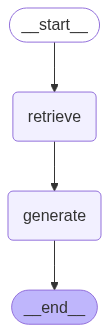

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
result = graph.invoke({"question": "What is the objective of Chief Executive Officer at Contoso Electronics?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='486a2396-88e2-4e29-9908-f03fd9ea5ba0', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 2, 'page_label': '3', 'start_index': 0}, page_content='Contoso Electronics Role Library \nLast Updated: 2023-03-05 \nChief Executive Officer \n \nJob Description: \n \nPosition: Chief Executive Officer  \nCompany: Contoso Electronics  \n \nObjective: \nThe Chief Executive Officer (CEO) will be responsible for providing strategic direction and \noversight to Contoso Electronics, to ensure the company’s long-term success and \nprofitability.  \n \nResponsibilities: \n• Develop and implement strategy and objectives to ensure the financial success and long-\nterm growth of the company  \n• Provide strategic guidance and direction to the executive team and manage the day-to-day \noperations of the company \n• Ensure compliance with all la

In [19]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [20]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[2].metadata

{'producer': 'PyPDF2',
 'creator': 'PyPDF',
 'creationdate': '',
 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf',
 'total_pages': 263,
 'page': 2,
 'page_label': '3',
 'start_index': 0,
 'section': 'beginning'}

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore(embedding_model)
_ = vectorstore.add_documents(all_splits)

In [22]:
from typing import Literal

from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [23]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vectorstore.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

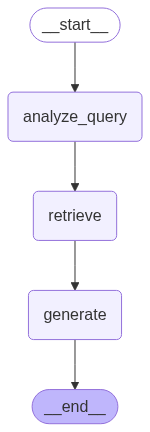

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for step in graph.stream(
    {"question": "What is the objective of Chief Executive Officer at Contoso Electronics?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'objective of Chief Executive Officer at Contoso Electronics', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='9fdf2d45-dd4e-4109-b6a6-ed555c3ae7bf', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 2, 'page_label': '3', 'start_index': 0, 'section': 'beginning'}, page_content='Contoso Electronics Role Library \nLast Updated: 2023-03-05 \nChief Executive Officer \n \nJob Description: \n \nPosition: Chief Executive Officer  \nCompany: Contoso Electronics  \n \nObjective: \nThe Chief Executive Officer (CEO) will be responsible for providing strategic direction and \noversight to Contoso Electronics, to ensure the company’s long-term success and \nprofitability.  \n \nResponsibilities: \n• Develop and implement strategy and objectives to ensure the financial success and lon

In [26]:
for step in graph.stream(
    {"question": "What are the different plans in Northwind Health Plus insurance?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Northwind Health Plus insurance plans', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='b7470153-b95c-4b40-91fa-114c8ebbb393', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 37, 'page_label': '38', 'start_index': 0, 'section': 'beginning'}, page_content='Summary of Benefits \nNorthwind Standard \nNorthwind Standard is a basic plan that provides coverage for medical, vision, and dental \nservices. This plan also offers coverage for preventive care services, as well as prescription \ndrug coverage. With Northwind Standard, you can choose from a variety of in-network \nproviders, including primary care physicians, specialists, hospitals, and pharmacies. This \nplan does not offer coverage for emergency services, mental health and substance abuse \ncoverage, or out-of-ne

In [ ]:
for step in graph.stream(
    {"question": "What are covered services in Northwind Standard plan?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Northwind Standard plan covered services', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='db030c03-bd9b-4174-ba10-e08a52f79ba0', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 79, 'page_label': '80', 'start_index': 0, 'section': 'beginning'}, page_content='By following these tips, you can make sure that you are taking advantage of all the benefits \nof the Northwind Standard plan. With the right plan in place, you can be sure that you are \ngetting the best coverage for your medical, dental, vision, and prescription drug needs. \nPreventive Care \nCOVERED SERVICES: Preventive Care \nAt Northwind Health, preventive care services are covered under the Northwind Standard \nplan. Preventive care services are a great way to stay on top of your health, and they are \navai

In [ ]:
for step in graph.stream(
    {"question": "What are the qualifications for Chief Operating Officer?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'qualifications for Chief Operating Officer', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='aabcd706-567e-4bdc-9fb7-7bc2864feab0', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 3, 'page_label': '4', 'start_index': 766, 'section': 'beginning'}, page_content='objectives  \n• Create and manage key performance indicators for all departments  \n• Analyze existing systems and processes, identify areas of improvement, and implement \nsolutions  \n• Develop and nurture relationships with key stakeholders, including customers and \nvendors  \n• Act as an advisor to the CEO, board of directors, and executive team  \n• Prepare and present reports to the board of directors  \n• Manage the budget and ensure that the organization is operating within its means  \n• Ensure complia

In [ ]:
for step in graph.stream(
    {"question": "Could you please give me the job summary for director of sales"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'job summary for director of sales', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='b637e383-b97d-4f2b-8da7-d069dd53de24', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 11, 'page_label': '12', 'start_index': 1558, 'section': 'beginning'}, page_content='manage products through their lifecycle \n• Demonstrated ability to collaborate cross-functionally and manage multiple projects \nsimultaneously \n• Exceptional attention to detail and problem-solving skills \n• Excellent communication, interpersonal, and organizational skills \n• Knowledge of the consumer electronics industry and market trends \nDirector of Sales \n \nPosition: Director of Sales, Contoso Electronics \n \nJob Summary:  \nThe Director of Sales will lead the sales team in achieving strategic and operati

In [31]:
for step in graph.stream(
    {"question": "compare the northwind standard and northwind plus plans"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Northwind Standard vs Northwind Plus plans comparison', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='b7470153-b95c-4b40-91fa-114c8ebbb393', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 37, 'page_label': '38', 'start_index': 0, 'section': 'beginning'}, page_content='Summary of Benefits \nNorthwind Standard \nNorthwind Standard is a basic plan that provides coverage for medical, vision, and dental \nservices. This plan also offers coverage for preventive care services, as well as prescription \ndrug coverage. With Northwind Standard, you can choose from a variety of in-network \nproviders, including primary care physicians, specialists, hospitals, and pharmacies. This \nplan does not offer coverage for emergency services, mental health and substance abuse \ncovera

In [29]:
for step in graph.stream(
    {"question": "What is the mission of Contoso Electronics?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'mission of Contoso Electronics', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='56439bc6-1e49-4e5a-8312-f5f0a699a24a', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 0, 'page_label': '1', 'start_index': 0, 'section': 'beginning'}, page_content='Roles Descriptions at \nContoso Electronics'), Document(id='134ce297-272c-4d27-bc10-9fb59679a5b4', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 12, 'page_label': '13', 'start_index': 1541, 'section': 'beginning'}, page_content='The Director of Marketing for Contoso Electronics is responsible for developing, \nimplementing, and executing strategies to increase brand awareness and

In [ ]:
for step in graph.stream(
    {"question": "What are the missions of the company?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What are the missions of the company?', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='812dcbfc-3672-41d9-a560-4ee5c744e109', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'source': '/home/tulasiram/ubuntu_server/RAG_ChatApp_LangChain/Output_Data/merged_output.pdf', 'total_pages': 263, 'page': 13, 'page_label': '14', 'start_index': 1451, 'section': 'beginning'}, page_content='product delivery. \n \nResponsibilities: \n \n• Develop and implement strategies to improve operational efficiency and productivity \n• Analyze and track performance metrics to improve operational processes \n• Lead the team in developing and implementing processes to maintain operational \nexcellence \n• Establish customer service standards and ensure adherence \n• Develop and implement strategies to manage inventory and stock levels \n• Manage the budget and financial operations of the company \n• Oversee the re